This is the first notebook of the exploratory data analysis part. It will explore the lyrics, computing word frequencies and performing sentiment analysis.

In [3]:
import nltk,re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import spacy
import math
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval


In [4]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download("wordnet")
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
repository = 'data/'
songs_df = pd.read_csv(repository + 'genius_song_lyrics.csv')
songs_df

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\GuillaumeGuers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GuillaumeGuers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\GuillaumeGuers\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GuillaumeGuers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------- ---------------------------- 3.7/12.8 MB 19.8 MB/s eta 0:00:01
     ------------------------ --------------- 7.9/12.8 MB 19.4 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 20.2 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 18.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,title,tag,artist,year,lyrics,views,rank
0,Shape of You,pop,Ed Sheeran,2017,[Verse 1]\nThe club isn't the best place to fi...,14569727,1
1,​thank u next,pop,Ariana Grande,2018,[Verse 1]\nThought I'd end up with Sean\nBut h...,9072131,2
2,Work,pop,Rihanna,2016,"[Chorus: Rihanna]\nWork, work, work, work, wor...",7871555,3
3,Too Good at Goodbyes,pop,Sam Smith,2017,[Verse 1]\nYou must think that I'm stupid\nYou...,7784454,4
4,7 rings,pop,Ariana Grande,2019,"[Verse 1]\nYeah, breakfast at Tiffany's and bo...",7387794,5
...,...,...,...,...,...,...,...
359995,My Old Friend,rock,The Adicts,2012,Hello my dear old friend\nIt's nice to see you...,1153,119996
359996,The Ecstasy of Gold / Enter Sandman Live,rock,Metallica,1993,[Intro]\n[Instrumental: The Ecstasy of Gold]\n...,1153,119997
359997,Perfect,rock,Glitterer,2019,[Verse 1]\nI don't believe in perfect\nIt’s so...,1153,119998
359998,The Devil You Know,rock,I Fight Dragons,2019,"You pause and look around, no shelter to be fo...",1153,119999


# I - PREPROCESSING
Let's see what the lyrics look like and how much text pre-processing we have to do.

In [11]:
print(songs_df['lyrics'][0])

[Verse 1]
The club isn't the best place to find a lover
So the bar is where I go
Me and my friends at the table doing shots
Drinking fast and then we talk slow
And you come over and start up a conversation with just me
And trust me I'll give it a chance now
Take my hand, stop, put Van the Man on the jukebox
And then we start to dance, and now I'm singing like

[Pre-Chorus]
Girl, you know I want your love
Your love was handmade for somebody like me
Come on now, follow my lead
I may be crazy, don't mind me
Say, boy, let's not talk too much
Grab on my waist and put that body on me
Come on now, follow my lead
Come, come on now, follow my lead

[Chorus]
I'm in love with the shape of you
We push and pull like a magnet do
Although my heart is falling too
I'm in love with your body
And last night you were in my room
And now my bed sheets smell like you
Every day discovering something brand new
I'm in love with your body
[Post-Chorus]
Oh, I, oh, I, oh, I, oh, I
I'm in love with your body
Oh, I,

As we can see, the text seems already quite clean. There does not seem to be much weird symbols or metadata, the only things we'll have to manage are the verses and chorus indications, but they will be easy to remove as they always come into brackets. We will also perform a tokenization of the text to study the word frequencies.
### I.1 - Tokenization

In [12]:
# Define a list of stop words to remove from the lyrics
stop_words = ["'d", "'ll", "'m", "'re", "'s", "'ve", "n't",
                    "d", "ll", "m", "re", "s", "ve", "nt"]  # Contractions and auxiliaries

stop_words += [
    "and", "but", "or", "nor", "for", "yet", "so"  # Common conjunctions
]

stop_words += [
    "a", "an", "the", "this", "that", "these", "those", 'I', 'i', 'you', 'he',
    'she', 'it', 'we', 'they', "my", "your", "his", "her", "its", "our", "their",
    "which", "what", "whose"  # Articles, pronouns, and possessives
]

stop_words += [
    ".", ",", "!", "?", ";", ":",  # Punctuation
    "'", '"', "(", ")", "[", "]", "{", "}",
    "-", "–", "—", "_", "/", "\\",  # More punctuation and symbols
    "&", "*", "@", "#", "%", "^", "°",
    "+", "=", "<", ">", "|", "~", "`", '’'
]

# Add NLTK's default English stop words
stop_words += stopwords.words('english')
# Convert the list to a set for faster lookups
stop_words = set(stop_words)
# Initialize a counter
counter = 0
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()
# Create a stemmer object
stemmer = PorterStemmer()

def tokenize(lyrics: str) -> list[str]:
    """
    Performs basic tokenization of song lyrics.

    This function removes section headers, converts text to lowercase,
    and splits the lyrics into individual words (tokens).

    Args:
        lyrics (str): The song lyrics to tokenize.

    Returns:
        list[str]: A list of tokens (words) extracted from the lyrics.
    """
    # Remove section headers like [Verse 1], [Chorus], etc.
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    lyrics = lyrics.replace('-', ' ').lower()

    # Tokenize by splitting on whitespace
    tokens = lyrics.split()

    return tokens

def advanced_tokenize(lyrics: str) -> list[str]:
    """
    Performs advanced tokenization of song lyrics.

    This function removes section headers, converts text to lowercase,
    tokenizes using NLTK's word_tokenize, lemmatizes words,
    removes stop words, and applies stemming.

    Args:
        lyrics (str): The song lyrics to tokenize.

    Returns:
        list[str]: A list of processed tokens extracted from the lyrics.
    """
    global counter
    counter += 1
    if counter % 1000 == 0:
        print(counter, round(counter / 3600, 2), '%')
    # Remove section headers like [Verse 1], [Chorus], etc.
    lyrics = re.sub(r'\[.*?\]', '', lyrics).lower()
    lyrics = re.sub('-', ' ', lyrics)
    tokens = word_tokenize(lyrics)  # Tokenize words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [13]:
# Tokenize the lyrics
songs_df['tokens'] = songs_df['lyrics'].apply(advanced_tokenize)
songs_df

1000 0.28 %
2000 0.56 %
3000 0.83 %


,title,tag,artist,year,lyrics,views,rank,tokens
0,Shape of You,pop,Ed Sheeran,2017,[Verse 1]\nThe club isn't the best place to fi...,14569727,1,"[club, best, place, find, lover, bar, go, frie..."
1,​thank u next,pop,Ariana Grande,2018,[Verse 1]\nThought I'd end up with Sean\nBut h...,9072131,2,"[thought, end, sean, wa, match, wrote, song, r..."
2,Work,pop,Rihanna,2016,"[Chorus: Rihanna]\nWork, work, work, work, wor...",7871555,3,"[work, work, work, work, work, work, said, haf..."
3,Too Good at Goodbyes,pop,Sam Smith,2017,[Verse 1]\nYou must think that I'm stupid\nYou...,7784454,4,"[must, think, stupid, must, think, fool, must,..."
4,7 rings,pop,Ariana Grande,2019,"[Verse 1]\nYeah, breakfast at Tiffany's and bo...",7387794,5,"[yeah, breakfast, tiffani, bottl, bubbl, girl,..."
...,...,...,...,...,...,...,...,...
240995,Sleepwalking,rock,Bring Me The Horizon,2013,[Verse 1]\nMy secrets are burning a hole throu...,211366,996,"[secret, burn, hole, heart, bone, catch, fever..."
240996,Can We Fix It?,rock,Bob the Builder,2001,[Chorus]\nBob the Builder!\nCan we fix it?\nBo...,211365,997,"[bob, builder, fix, bob, builder, ye, scoop, m..."
240997,Heavenly Father,rock,Bon Iver,2014,Ever since I heard the howlin' wind\nI didn't ...,211312,998,"[ever, sinc, heard, howlin, wind, need, go, bi..."
240998,Invincible,rock,Tool,2019,[Verse 1]\nLong in tooth and soul\nLonging for...,211106,999,"[long, tooth, soul, long, anoth, win, lurch, f..."


### I.2 - Useful processing
This cell prepares the data for analysis by:
1. Creating dictionaries to quickly access song and artist data by title/name.
2. Creating a new dataframe summarizing artist information (total views, song count, first year, rank).
3. Gathering and storing all tokens associated with each artist in the new dataframe

In [14]:
# Create a dictionary mapping lowercase song titles to their row indexes in songs_df, will be useful later.
title_indexes_dict = {}
for index, row in songs_df.iterrows():
    song_title = str(row['title']).strip().lower()  # Get song title, lowercase and strip whitespace
    if not song_title in title_indexes_dict:
        title_indexes_dict[song_title] = []  # Initialize list for this title if not present
    title_indexes_dict[song_title].append(index)  # Add the row index to the title's list


# Get the title of the most viewed song for each artist
most_viewed_songs = songs_df.loc[songs_df.groupby('artist')['views'].idxmax(), ['artist', 'title']]
most_viewed_songs = most_viewed_songs.rename(columns={'title': 'most_viewed_song'})  # Rename column

# Create a DataFrame summarizing artist data
artist_df = songs_df.groupby('artist').agg(
    total_views=('views', 'sum'),  # Total views for each artist
    num_songs=('title', 'count'),  # Number of songs by each artist
    first_year=('year', 'min')  # Earliest year a song by the artist appears
)
# Merge with most_viewed_songs to include the most viewed song information
artist_df = pd.merge(artist_df, most_viewed_songs, on='artist', how='left')

# Calculate rank based on total views (higher views = lower rank)
artist_df['rank'] = artist_df['total_views'].rank(ascending=False, method='dense').astype(int)

# Sort by rank and reset index
artist_df = artist_df.sort_values(by=['rank'])
artist_df.reset_index(inplace=True)

# Create a dictionary mapping artist names to all their tokens
artist_tokens = {}
for index, row in songs_df.iterrows():
    artist = row['artist']  # Get artist name
    tokens = row['tokens']  # Get tokens for the song
    if artist not in artist_tokens:
        artist_tokens[artist] = []  # Initialize list for this artist if not present
    artist_tokens[artist] += tokens  # Add the tokens to the artist's list

# Add the 'tokens' column to artist_df
artist_df['tokens'] = artist_df.set_index('artist').index.map(artist_tokens)

# Create a dictionary mapping lowercase artist names to their row indexes in artist_df, will be useful later.
artist_indexes_dict = {}
for index, row in artist_df.iterrows():
    artist_name = str(row['artist']).strip().lower()  # Get artist name, lowercase and strip whitespace
    if not artist_name in artist_indexes_dict:
        artist_indexes_dict[artist_name] = []  # Initialize list for this artist if not present
    artist_indexes_dict[artist_name].append(index)  # Add the row index to the artist's list

In [15]:
def show_titles(title: str):
    """
    Displays information about songs whose title matches the provided title. The function is case-INSENSITIVE,
    and is aimed to find songs by title.

    Args:
        title (str): The title of the song to search for.
    """
    indexes = title_indexes_dict.get(title.strip().lower(), [])  # Get row indexes for the title (case-insensitive)
    if indexes:  # If indexes were found (song exists)
        for index in indexes:
            row = songs_df.iloc[index]  # Get the row from songs_df using the index
            print(f"Title: {row['title']}")  # Print the song's title
            print(f"Artist: {row['artist']}")  # Print the song's artist
            print(f"Genre: {row['tag']}")  # Print the song's genre
            print(f"Year: {row['year']}")  # Print the song's release year
            print(f"Lyrics: {row['lyrics'][:100]}" + "...")  # Print the first 10 characters of lyrics
            print("-" * 60)  # Print a separator line
    else:
        print(f"No songs found with the title '{title}'")  # Print message if song not found


def show_artists(artist: str):
    """
    Displays information about artists whose name matches the provided artist name. The function is case-INSENSITIVE,
    and is aimed to find artists by name.

    Args:
        artist (str): The name of the artist to search for.
    """
    indexes = artist_indexes_dict.get(artist.strip().lower(), [])  # Get row indexes for the artist (case-insensitive)
    if indexes:  # If indexes were found (artist exists)
        for index in indexes:
            row = artist_df.iloc[index]  # Get the row from artist_df using the index
            print(f"Artist: {row['artist']}")  # Print the artist's name
            print(f"Total Views: {row['total_views']}")  # Print the artist's total views
            print(f"Rank: {row['rank']}")  # Print the artist's rank
            print(f"Number of Songs: {row['num_songs']}")  # Print the artist's number of songs
            print("-" * 60)  # Print a separator line
    else:
        print(f"No artists found with the name '{artist}'")  # Print message if artist not found

In [ ]:
show_titles('clocks')
show_artists('coldplay')

Title: Shape of You
Artist: Ed Sheeran
Genre: pop
Year: 2017
Lyrics: [Verse 1]
The club isn't the best place to find a lover
So the bar is where I go
Me and my friends a...
------------------------------------------------------------
Artist: Coldplay
Total Views: 7059263
Rank: 83
Number of Songs: 8
------------------------------------------------------------


# II - WORD FREQUENCIES
Now that the text is processed and we've defined handy functions, we can start seriously exloring our dataframes. Let's have a look a what our favourite singers are interested in singing!

### II.1 - Raw frequencies
Let's start simple and calculate word frequencies by artist or genre, and plot them with wordclouds. This cell defines two functions: `word_cloud` and `entities_wordcloud`.
Both functions generate and display word clouds based on song lyrics.
`word_cloud` creates a word cloud based on the frequency of words in the lyrics,
optionally filtered by genre and/or artist.
`entities_wordcloud` creates a word cloud based on named entities (like people, places, or organizations)
extracted from the lyrics, also optionally filtered by genre and/or artist.

In [19]:
def word_cloud(genre: str = None, artist: str = None, plot: bool = True):
    """
    Generates and displays a word cloud from song lyrics,
    optionally filtered by genre and/or artist.

    Args:
        genre (str, optional): The genre to filter by. Defaults to None.
        artist (str, optional): The artist to filter by. Defaults to None.
        plot (bool, optional): Whether to display the word cloud. Defaults to True.

    Returns:
        wordcloud.WordCloud: The generated word cloud object.
    """

    filtered_df = songs_df.copy()  # Create a copy of the songs dataframe to avoid modifying the original

    # Filter by genre if provided
    if genre:
        filtered_df = filtered_df[filtered_df['tag'] == genre]
    # Filter by artist if provided
    if artist:
        filtered_df = filtered_df[filtered_df['artist'] == artist]

    # Combine all lyrics tokens into a single string
    all_lyrics = []
    for tokens in filtered_df['tokens']:
        all_lyrics.extend(tokens)
    all_lyrics = ' '.join(all_lyrics)

    # Generate the word cloud
    wc = wordcloud.WordCloud(
        width=1000,  # Set the width of the word cloud
        height=1000,  # Set the height of the word cloud
        stopwords=[],  # No stopwords are used (text already tokenized)
        max_words=100,  # Maximum number of words to display
        collocations=False  # Do not include collocations (words that frequently appear together)
    ).generate(all_lyrics)  # Generate the word cloud from the lyrics

    # Display the word cloud if plot is True
    if plot:
        plt.figure(figsize=[10, 10])  # Create a figure with a specific size
        plt.imshow(wc, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
        plt.title(f"Word cloud for {genre} and {artist}")  # Set the title of the plot
        plt.axis("off")  # Turn off the axis
        plt.show()  # Show the plot

    return wc  # Return the word cloud object

# Does not work very well, as spacy struggles to fing entities
def entities_wordcloud(genre: str = None, artist: str = None, entities='name', plot: bool = True):
    """
    Generates and displays a word cloud from named entities in song lyrics,
    optionally filtered by genre and/or artist.

    Args:
        genre (str, optional): The genre to filter by. Defaults to None.
        artist (str, optional): The artist to filter by. Defaults to None.
        entities (str, optional): Whether to display entity names or labels. Defaults to 'name'.
        plot (bool, optional): Whether to display the word cloud. Defaults to True.

    Returns:
        wordcloud.WordCloud: The generated word cloud object.
    """
    entities_names = ''  # Initialize an empty string to store entity names
    entities_labels = ''  # Initialize an empty string to store entity labels
    filtered_df = songs_df.copy()
    # Filter by genre if provided
    if genre:
        filtered_df = filtered_df[filtered_df['tag'] == genre]
    # Filter by artist if provided
    if artist:
        filtered_df = filtered_df[filtered_df['artist'] == artist]

    # Iterate through the lyrics and extract entities
    for lyrics in filtered_df['lyrics']:
        doc = nlp(lyrics)  # Process the lyrics using spaCy
        for ent in doc.ents:  # Iterate through the entities found in the lyrics
            entities_names += ent.text + ' '  # Add the entity name to the entities_names string
            entities_labels += ent.label_ + ' '  # Add the entity label to the entities_labels string
    if not entities_names:
        entities_names = 'NoneFound'
        entities_labels = 'NoneFound'
    # Generate the word cloud based on entity names or labels
    if entities == 'name':
        wc = wordcloud.WordCloud(
            width=1000,
            height=1000,
            stopwords=[],
            max_words=100,
            collocations=False
        ).generate(entities_names)  # Generate the word cloud from entity names
    else:
        wc_labels = wordcloud.WordCloud(
            width=1000,
            height=1000,
            stopwords=[],
            max_words=100,
            collocations=False
        ).generate(entities_labels)  # Generate the word cloud from entity labels

    # Display the word cloud if plot is True
    if plot:
        plt.figure(figsize=[10, 10])  # Create a figure with a specific size
        plt.imshow(wc, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
        plt.title(f"Entities {entities} word cloud for {genre} and {artist}")  # Set the title of the plot
        plt.axis("off")  # Turn off the axis
        plt.show()  # Show the plot

    return wc  # Return the word cloud object

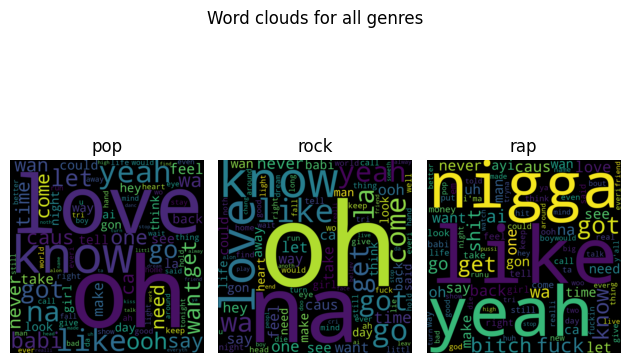

In [20]:
fig, axes = plt.subplots(1, 3)  # Create subplots
genres = ['pop', 'rock', 'rap']
for i, genre in enumerate(genres):
  wc = word_cloud(genre=genre, plot=False)  # Generate word cloud without plotting
  #wc = entities_wordcloud(genre=genre, plot=False) #Use entities instead of normal words,
  # running it can prove very long
  axes[i].imshow(wc, interpolation='bilinear')  # Display word cloud on subplot
  axes[i].set_title(f"{genre}")  # Set subplot title
  axes[i].axis("off")  # Turn off subplot axis

fig.suptitle('Word clouds for all genres')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Show the figure


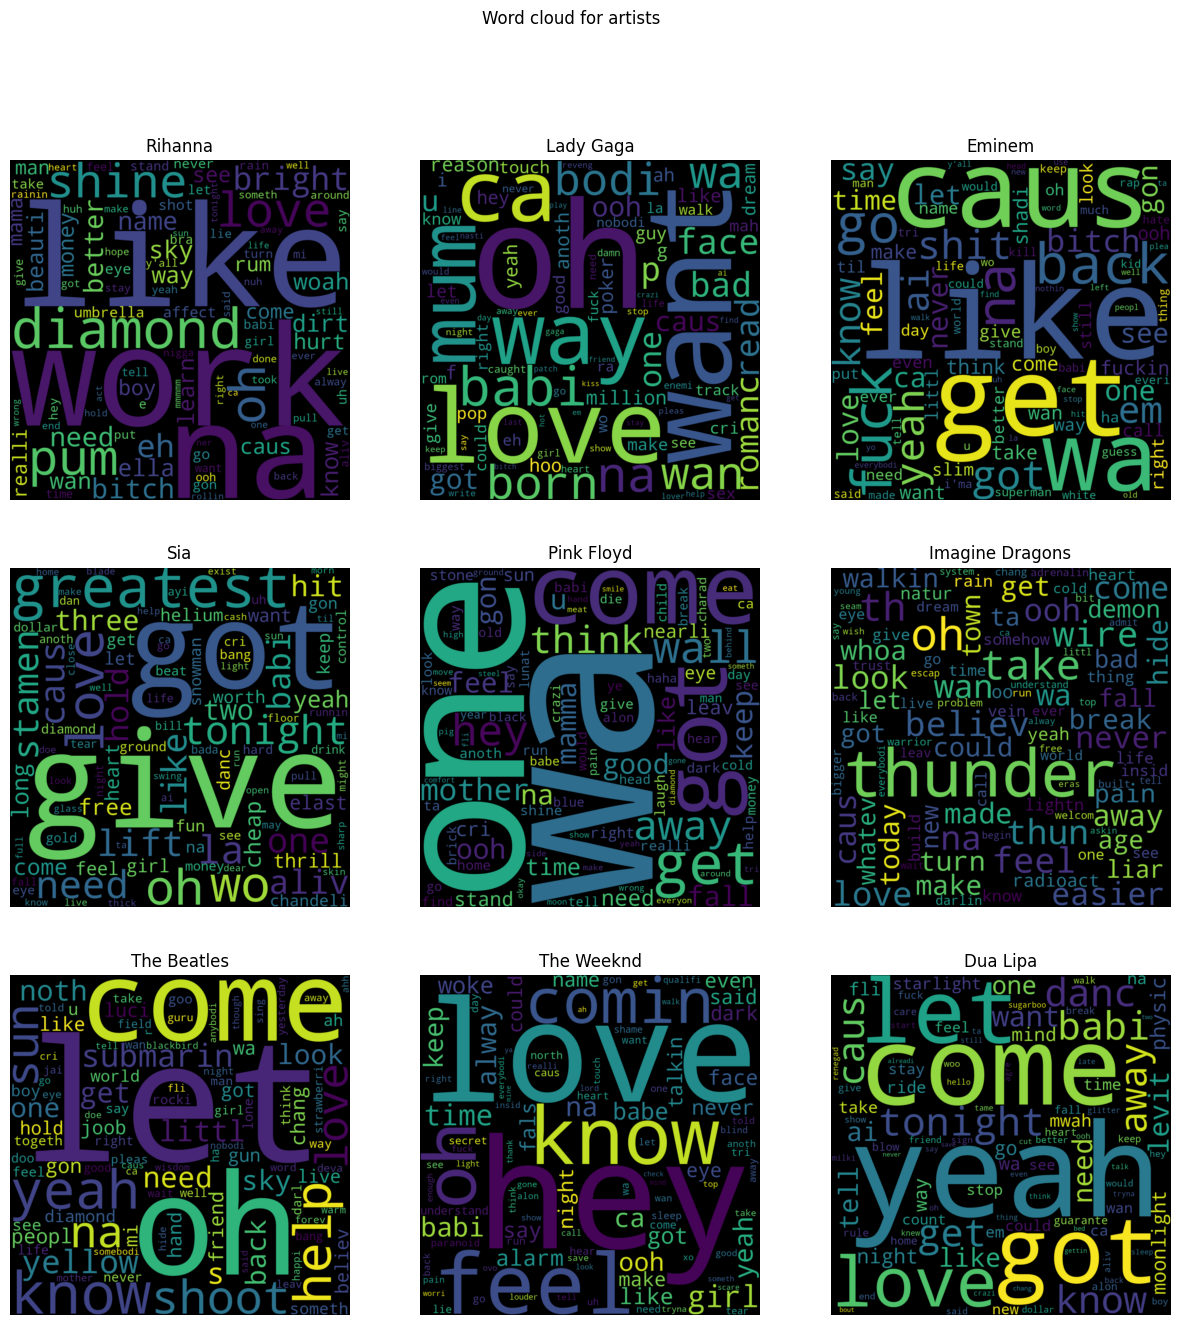

In [21]:
artists = ['Rihanna', 'Lady Gaga', 'Eminem','Sia','Pink Floyd',
           'Imagine Dragons','The Beatles','The Weeknd', 'Dua Lipa']

num_cols = 3
num_rows = math.ceil(len(artists) / num_cols)  # Calculate rows based on columns

# Create the subplots in a grid layout
subplot_width = 5
subplot_height = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_width, num_rows * subplot_height))
# Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through artists and plot word clouds
for i, artist in enumerate(artists):
    wc = word_cloud(artist=artist, plot=False)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"{artist}")
    axes[i].axis("off")

# Hide any extra empty subplots
for i in range(len(artists), len(axes)):
    axes[i].axis('off')  # Hide unused subplots to avoid empty spaces

fig.suptitle('Word cloud for artists')
#plt.tight_layout()
plt.show()

### II.2 - TF-IDF
Now let's refine this job. We'll do the same thing, except we'll use TF-IDF compute our frequencies. That should give us a first hint at our singers' preferences.

In [22]:
onomatopoeias = [
    "boom", "bap", "pow", "bang", "clap", "snap", "tap", "tick", "tock",
    "ding", "dong", "pop", "beep", "bop", "thump", "wham", "crash", "tsk",
    "click", "clack", "ring", "ting", "zing", "swoosh", "swish", "ching",
    "ratta-tat-tat", "ka-boom", "ka-ching", "boom-boom", "boom-bap", "brrrt",
    "vroom", "bling", "la-la-la", "sha-la-la", "na-na-na", "dum-da-dum",
    "ba-da-bing", "doo-wop", "shoo-be-doo", "fa-la-la", "uh-huh", "uh-oh",
    "ooh", "aah", "mmm", "yeah", "woo", "ay", "skrrt", "pew-pew","la","na","ba","doo",
    "oh","ah","uh","eh"
]
# 1. Create a TfidfVectorizer object to calculate TF-IDF values
tfidf_vectorizer = TfidfVectorizer(
            norm=None,  # TF-IDF values are not normalized
            use_idf=True,  # Use Inverse Document Frequency (IDF)
            smooth_idf=False,
            stop_words= onomatopoeias
            # Disable smoothing of IDF values, we want to boost the
            #words rarity score, because there are lots of artists
        )

# 2. Calculate TF-IDF for all artists' lyrics and store in a matrix
artists_matrix = tfidf_vectorizer.fit_transform(artist_df['tokens'].apply(lambda x: ' '.join(x)).tolist())

# 3. Get the list of unique words (features) found in the songs
feature_names = tfidf_vectorizer.get_feature_names_out()

# 4. Create a dictionary to map artist names to their index in the matrix
artist_dict = {v: k for k, v in artist_df['artist'].to_dict().items()}

# Define a function to generate a word cloud based on TF-IDF scores
def tfidf_wordcloud(artist :str, plot: bool=True) :
    """Generates and displays a word cloud for a given artist using TF-IDF.

    Args:
        artist (str): The name of the artist for whom to generate the word cloud.
        plot (bool, optional): Whether to display the word cloud. Defaults to True.

    Returns:
        wordcloud.WordCloud: The generated word cloud object.
    """
    if artist not in artist_dict:
        print(f"Artist '{artist}' not found in the dataset.")
        return

    # Get TF-IDF scores for the artist
    tfidf_scores = artists_matrix[artist_dict[artist]].toarray().flatten()

    # Create a dictionary mapping words to their TF-IDF scores
    word_scores = dict(zip(feature_names, tfidf_scores))

    # Generate the word cloud
    wc = wordcloud.WordCloud(
    width=1000,
    height=1000,
    stopwords=[],
    max_words=100,
    collocations=False
).generate_from_frequencies(word_scores)

    # Display the word cloud if plot is True
    if plot:
      plt.figure(figsize=[10, 10])
      plt.imshow(wc, interpolation='bilinear')
      plt.axis("off")
      plt.title(f"Word Cloud for {artist} (TF-IDF)")
      plt.show()

    return wc


# Define a function to predict the artist based on lyrics (does not work very well, there too many artists)
def find_artist(lyrics: str):
    """Predicts the artist of a song based on its lyrics using TF-IDF and cosine similarity.

    Args:
        lyrics (str): The lyrics of the song for which to predict the artist.

    Returns:
        str: The name of the most likely artist, or "Unknown" if no match is found.
    """
    # Preprocess the input lyrics
    tokens = ' '.join(advanced_tokenize(lyrics))

    # Transform the lyrics into a TF-IDF vector
    lyrics_vector = tfidf_vectorizer.transform([tokens])

    # Calculate cosine similarity with all artists' vectors
    similarities = cosine_similarity(lyrics_vector, artists_matrix)[0]

    # Get the indices of the most similar artists
    indexes = similarities.argsort()[:3]

    # Get the artist name(s)
    try:
        artist_name = artist_df.iloc[indexes]['artist']
    except IndexError:
        artist_name = "Unknown"

    return artist_name

c:\Users\GuillaumeGuers\Entornos\test\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['be', 'bing', 'da', 'dum', 'fa', 'huh', 'ka', 'pew', 'ratta', 'sha', 'shoo', 'tat', 'wop'] not in stop_words.
  warnings.warn(


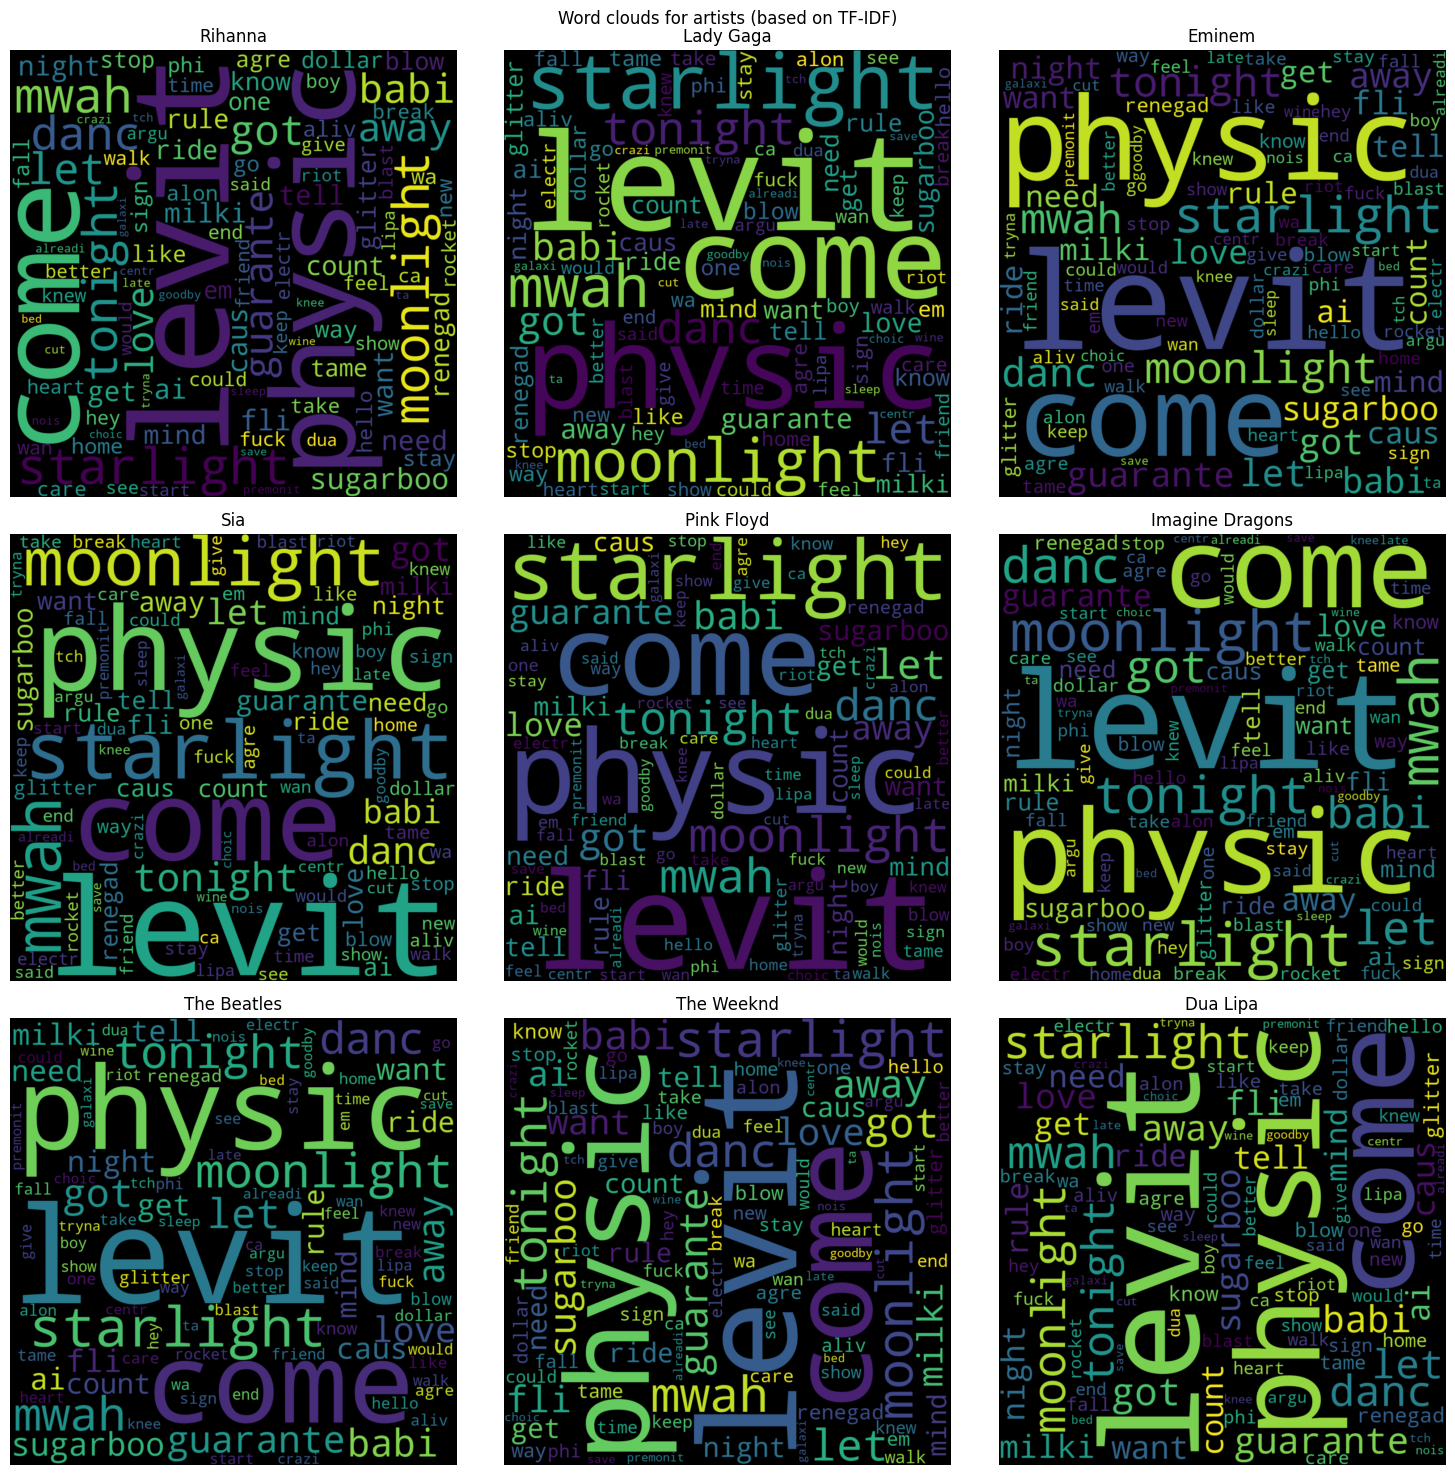

In [23]:
artists = ['Rihanna', 'Lady Gaga', 'Eminem','Sia','Pink Floyd',
           'Imagine Dragons','The Beatles','The Weeknd', 'Dua Lipa']

num_cols = 3
num_rows = math.ceil(len(artists) / num_cols)  # Calculate rows based on columns

# Create the subplots in a grid layout
subplot_width = 5
subplot_height = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_width, num_rows * subplot_height))
# Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, genre in enumerate(artists):
  wc = tfidf_wordcloud(artist=artist, plot=False)  # Generate word cloud without plotting
  #wc = entities_wordcloud(genre=genre, plot=False) #Use entities instead of normal words,
  axes[i].imshow(wc, interpolation='bilinear')  # Display word cloud on subplot
  axes[i].set_title(f"{genre}")  # Set subplot title
  axes[i].axis("off")  # Turn off subplot axis

fig.suptitle('Word clouds for artists (based on TF-IDF)')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Show the figure

We see that even with TF-IDF, it is difficult to grasp the words and themes are specific to the artists, because the tf part of the tf idf prevails over the idf part, so we would need a different formula. We could take the same formula but without applying the log to the idf for example.

# III - SENTIMENT ANALYSIS
After having discovered what people love to sing about, let's find out who is joyful and who is angry/sad  by performing a sentiment analysis.



In [ ]:
# Initialize the SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Initialize a counter variable (likely for tracking progress)
counter = 0

def compute_valence(text: str):
    """
    Calculates the sentiment valence (compound score) of a given text using VADER.

    Args:
        text (str): The input text for sentiment analysis.

    Returns:
        float: The compound sentiment score, ranging from -1 (negative) to 1 (positive).
    """
    global counter  # Access the global counter variable
    counter += 1  # Increment the counter
    if counter % 1000 == 0:  # Print progress every 1000 iterations
        print(counter, round(100 * counter / len(songs_df), 2), '%')

    # Calculate sentiment scores using the SentimentIntensityAnalyzer
    score = sentiment_analyzer.polarity_scores(text)

    # Return the compound sentiment score
    return score['compound']

# Apply the compute_valence function to the 'lyrics' column of songs_df to calculate valence for each song
songs_df['valence'] = songs_df['lyrics'].apply(compute_valence)
#songs_df.to_csv(repository + 'genius_song_lyrics_tokenized.csv', index=False)
# Group by artist and calculate the average valence for each artist
valence_by_artist = songs_df.groupby('artist')['valence'].mean().reset_index()

# Record the average valence in a column of the artists dataframe and saving it to a csv
artist_df = pd.merge(artist_df, valence_by_artist, on='artist', how='left')
#artist_df.to_csv(repository + 'genius_artists.csv', index=False)
songs_df

1000 33.33 %
2000 66.67 %
3000 100.0 %


,title,tag,artist,year,lyrics,views,rank,tokens,valence
0,Shape of You,pop,Ed Sheeran,2017,[Verse 1]\nThe club isn't the best place to fi...,14569727,1,"[club, best, place, find, lover, bar, go, frie...",0.9993
1,​thank u next,pop,Ariana Grande,2018,[Verse 1]\nThought I'd end up with Sean\nBut h...,9072131,2,"[thought, end, sean, wa, match, wrote, song, r...",0.9996
2,Work,pop,Rihanna,2016,"[Chorus: Rihanna]\nWork, work, work, work, wor...",7871555,3,"[work, work, work, work, work, work, said, haf...",-0.9978
3,Too Good at Goodbyes,pop,Sam Smith,2017,[Verse 1]\nYou must think that I'm stupid\nYou...,7784454,4,"[must, think, stupid, must, think, fool, must,...",-0.9770
4,7 rings,pop,Ariana Grande,2019,"[Verse 1]\nYeah, breakfast at Tiffany's and bo...",7387794,5,"[yeah, breakfast, tiffani, bottl, bubbl, girl,...",0.9972
...,...,...,...,...,...,...,...,...,...
240995,Sleepwalking,rock,Bring Me The Horizon,2013,[Verse 1]\nMy secrets are burning a hole throu...,211366,996,"[secret, burn, hole, heart, bone, catch, fever...",0.9685
240996,Can We Fix It?,rock,Bob the Builder,2001,[Chorus]\nBob the Builder!\nCan we fix it?\nBo...,211365,997,"[bob, builder, fix, bob, builder, ye, scoop, m...",0.9738
240997,Heavenly Father,rock,Bon Iver,2014,Ever since I heard the howlin' wind\nI didn't ...,211312,998,"[ever, sinc, heard, howlin, wind, need, go, bi...",0.9928
240998,Invincible,rock,Tool,2019,[Verse 1]\nLong in tooth and soul\nLonging for...,211106,999,"[long, tooth, soul, long, anoth, win, lurch, f...",0.7293


In [26]:
def most_positive_songs(genre: str = None, artist: str = None, most_negative:bool=False):
    """
    Returns the top 10 songs with the highest/lowest valence (most positive/negative sentiment),
    optionally filtered by genre and/or artist.

    Args:
        genre (str, optional): The genre to filter by. Defaults to None.
        artist (str, optional): The artist to filter by. Defaults to None.
        most_negative (bool, optional): Whether to return the most negative songs. Defaults to False.

    Returns:
        pandas.DataFrame: A DataFrame containing the top 10 songs, sorted by valence.
    """

    filtered_df = songs_df.copy()  # Assuming 'df' is your DataFrame containing song data

    if genre:
        filtered_df = filtered_df[filtered_df['tag'] == genre]
    if artist:
        filtered_df = filtered_df[filtered_df['artist'] == artist]

    # Sort by valence in descending order and take the top 10
    top_songs = filtered_df.sort_values(by=['valence'], ascending=most_negative).head(10)

    return top_songs


In [27]:
most_positive_songs(artist= 'Sting')

,title,tag,artist,year,lyrics,views,rank,tokens,valence
240963,Englishman in New York,rock,Sting,1987,"[Verse 1]\nI don't drink coffee, I'll take tea...",217629,964,"[drink, coffe, take, tea, dear, like, toast, d...",-0.9207
240411,Shape of My Heart,rock,Sting,1993,[Verse 1]\nHe deals the cards as a meditation\...,381320,412,"[deal, card, medit, play, never, suspect, doe,...",-0.9739


In [28]:
# Group by genre and calculate average valence
genre_valence = songs_df.groupby('tag')['valence'].mean().sort_values(ascending=False)
print(genre_valence)

tag
pop     0.415958
rock    0.193993
rap    -0.220344
Name: valence, dtype: float64


In [29]:
# Showing the most positive/negative artists
artist_valence = artist_df.sort_values(by=['valence'],ascending=False)
artist_valence.head(10)

,index,artist,total_views,num_songs,first_year,most_viewed_song,rank,tokens,valence
439,1015,Yelawolf,1266372,1,2015,Best Friend,440,"[ai, never, much, church, type, believ, last, ...",0.9999
920,765,Redbone,337909,1,1974,Come and Get Your Love,921,"[come, get, love, come, get, love, come, get, ...",0.9998
528,53,Angel Lyrics - The Weeknd,1036110,1,2015,Angel,529,"[ooh, ooh, ooh, ooh, oh, oh, yeah, yeah, hey, ...",0.9998
725,424,Jeff Buckley,655454,1,1994,Hallelujah,726,"[well, heard, wa, secret, chord, david, play, ...",0.9997
457,487,Kiiara,1221253,1,2015,Gold,458,"[roof, wa, let, love, know, roof, wa, let, lov...",0.9997
711,280,Dua Lipa & BLACKPINK,671620,1,2018,Kiss and Make Up,712,"[talk, morn, bang, head, bang, head, wall, sca...",0.9997
356,532,Liam Payne,1621801,1,2017,Strip That Down,357,"[huncho, quavo, yo, yo, know, take, time, keep...",0.9997
1036,288,Echosmith,223296,1,2013,Cool Kids,1037,"[see, walk, straight, line, realli, style, got...",0.9996
704,719,"PewDiePie, Roomie & Boyinaband",691464,1,2019,Congratulations,705,"[seri, yeah, big, day, woo, incred, job, know,...",0.9996
449,336,Frankie Valli,1243780,1,1967,Cant Take My Eyes Off You,450,"[good, true, ca, take, eye, like, heaven, touc...",0.9996
